In [1]:
import numpy as np
import patsy
import model

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

### Generate data using B-splines and map to trendfiltering basis function

### Zeroth degree, first order

Signal-to-noise ratio: 251.801


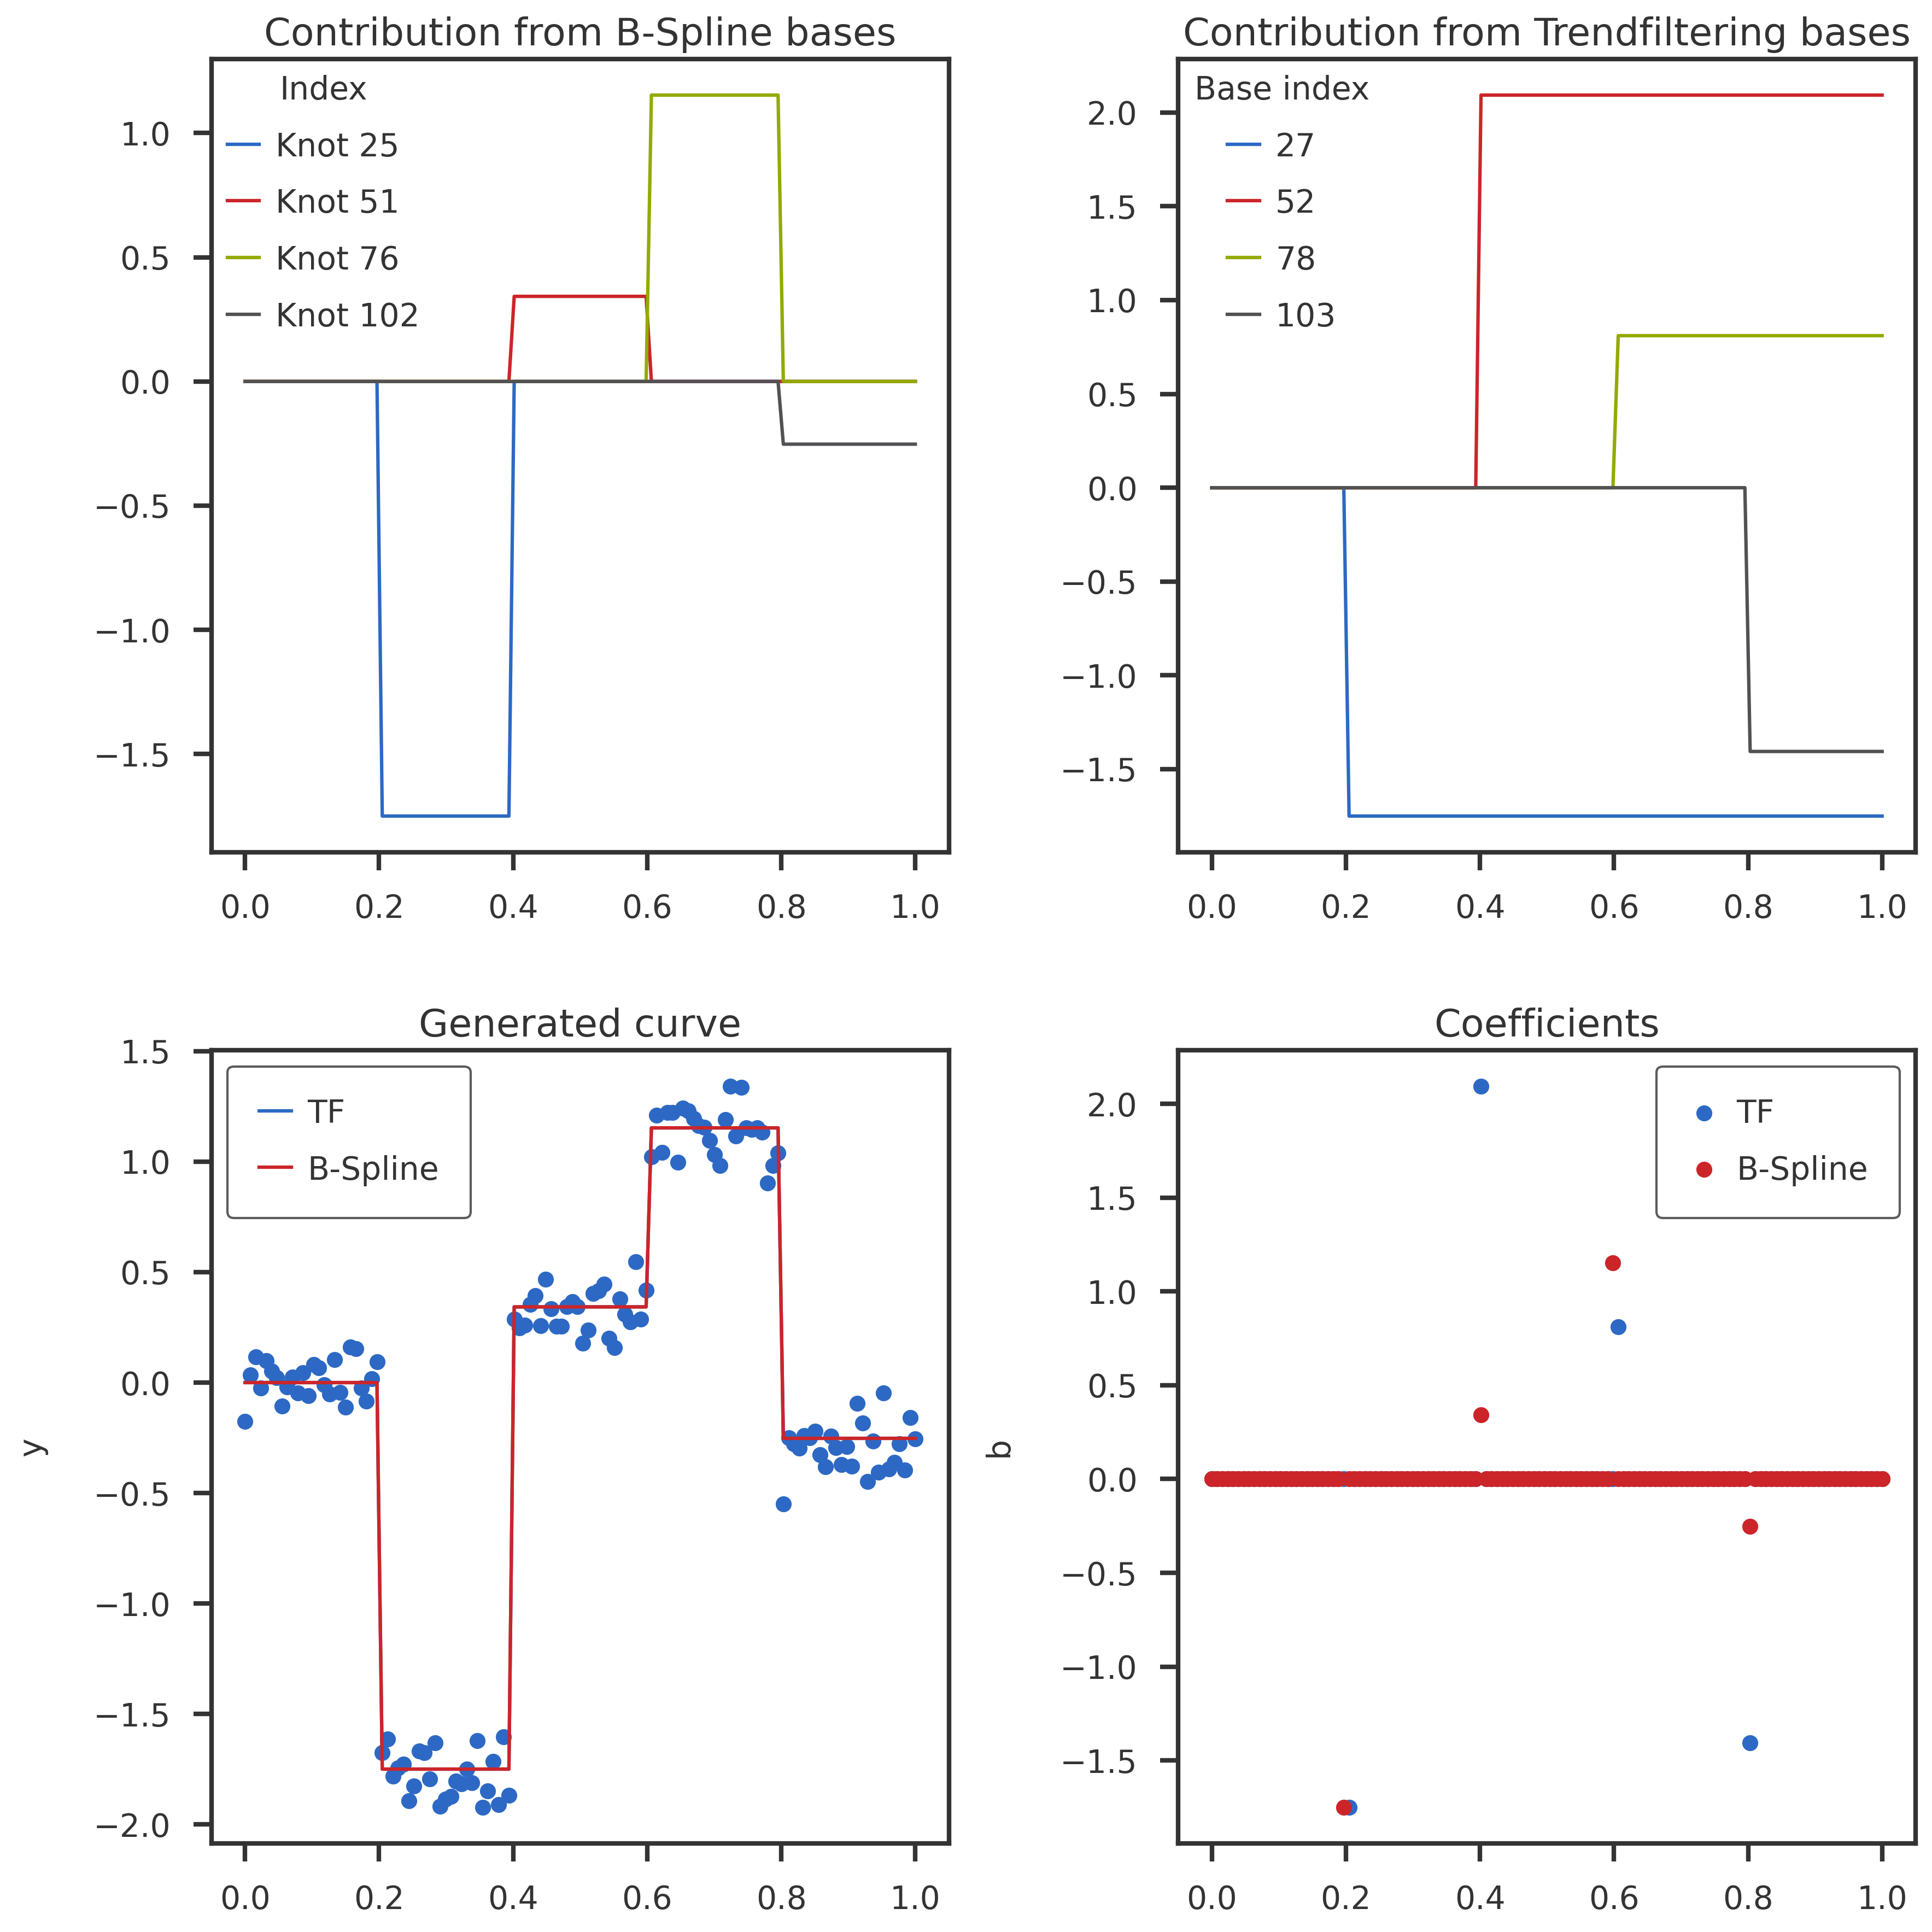

In [5]:
n = 128
x = np.linspace(0, 1, n)
np.random.seed(100)

# Zeroth degree trendfiltering
k = 4
degree = 0
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, k+2)[1:-1]
bfix = np.random.normal(0, 1, size = k + degree)


H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-4
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

### first degree, second order 

Signal-to-noise ratio: 0.229


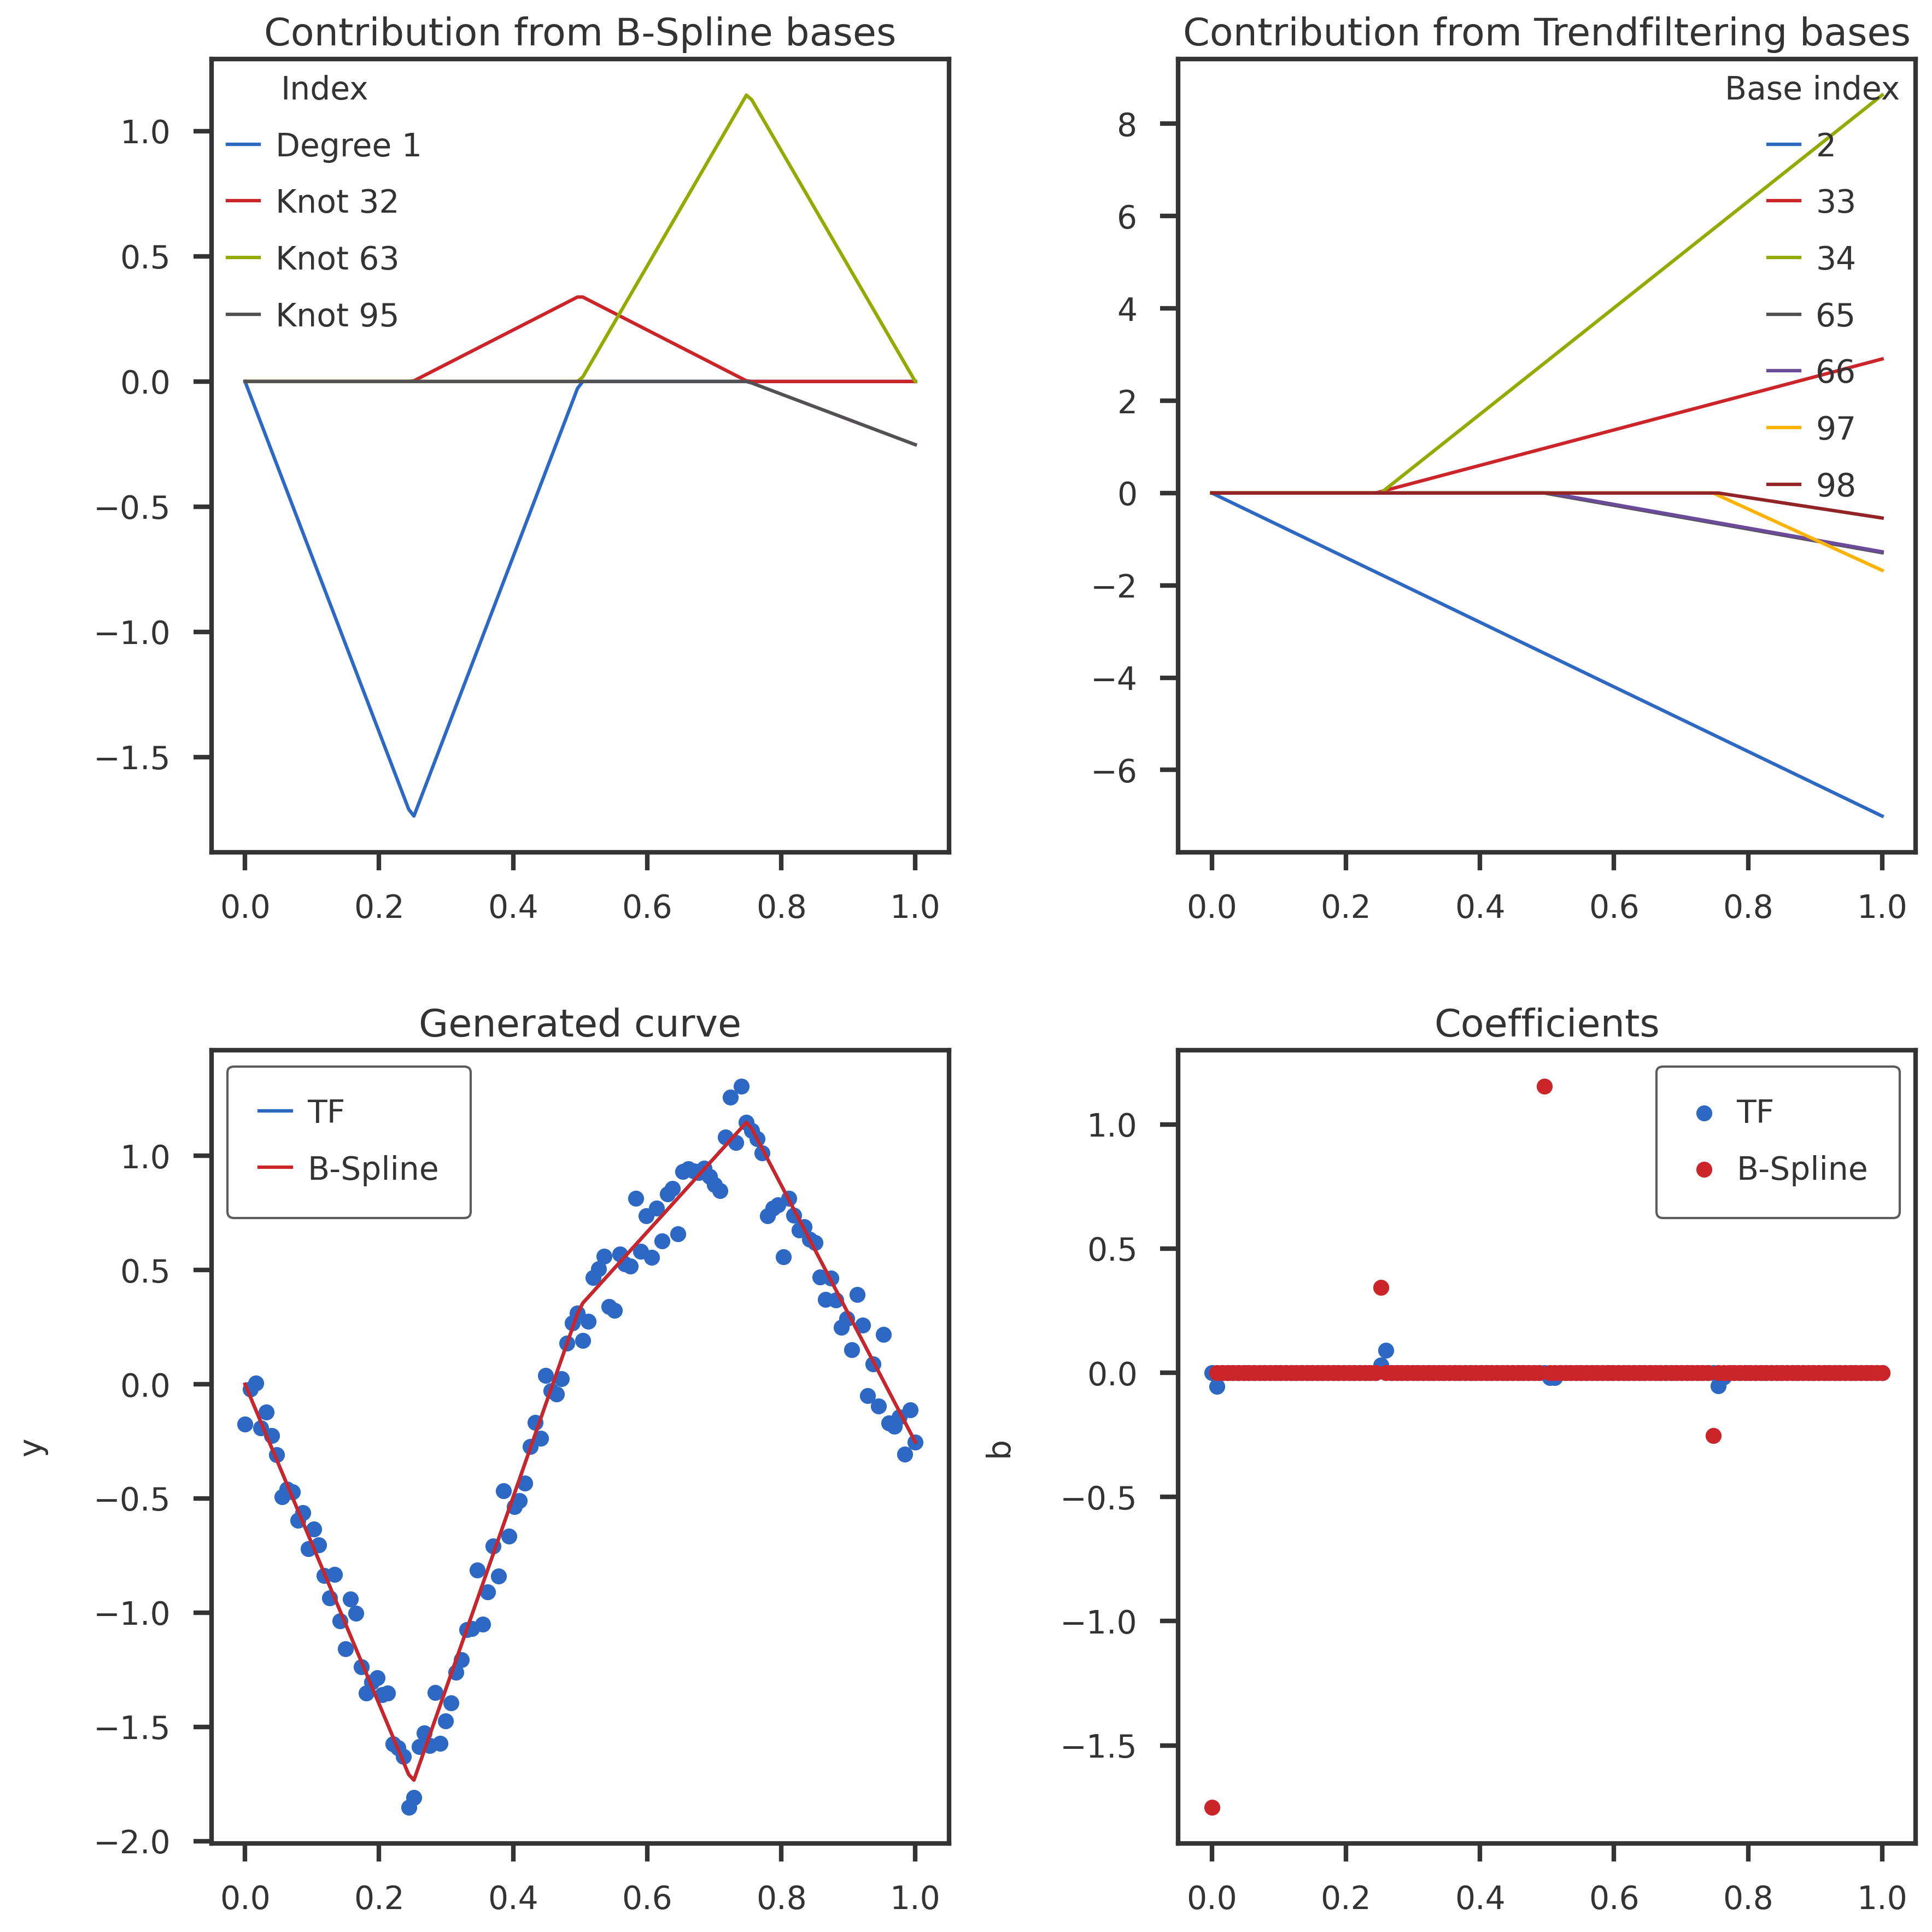

In [7]:
n = 128
x = np.linspace(0, 1, n)
np.random.seed(100)

# Linear trendfiltering
k = 3
degree = 1
strue = 0.1
include_intercept = False
knots = np.linspace(0, 1, k+2)[1:-1]
bfix = np.random.normal(0, 1, size = k + degree)

H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-4
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

### third degree, fourth order, cubic spline

Signal-to-noise ratio: 0.012


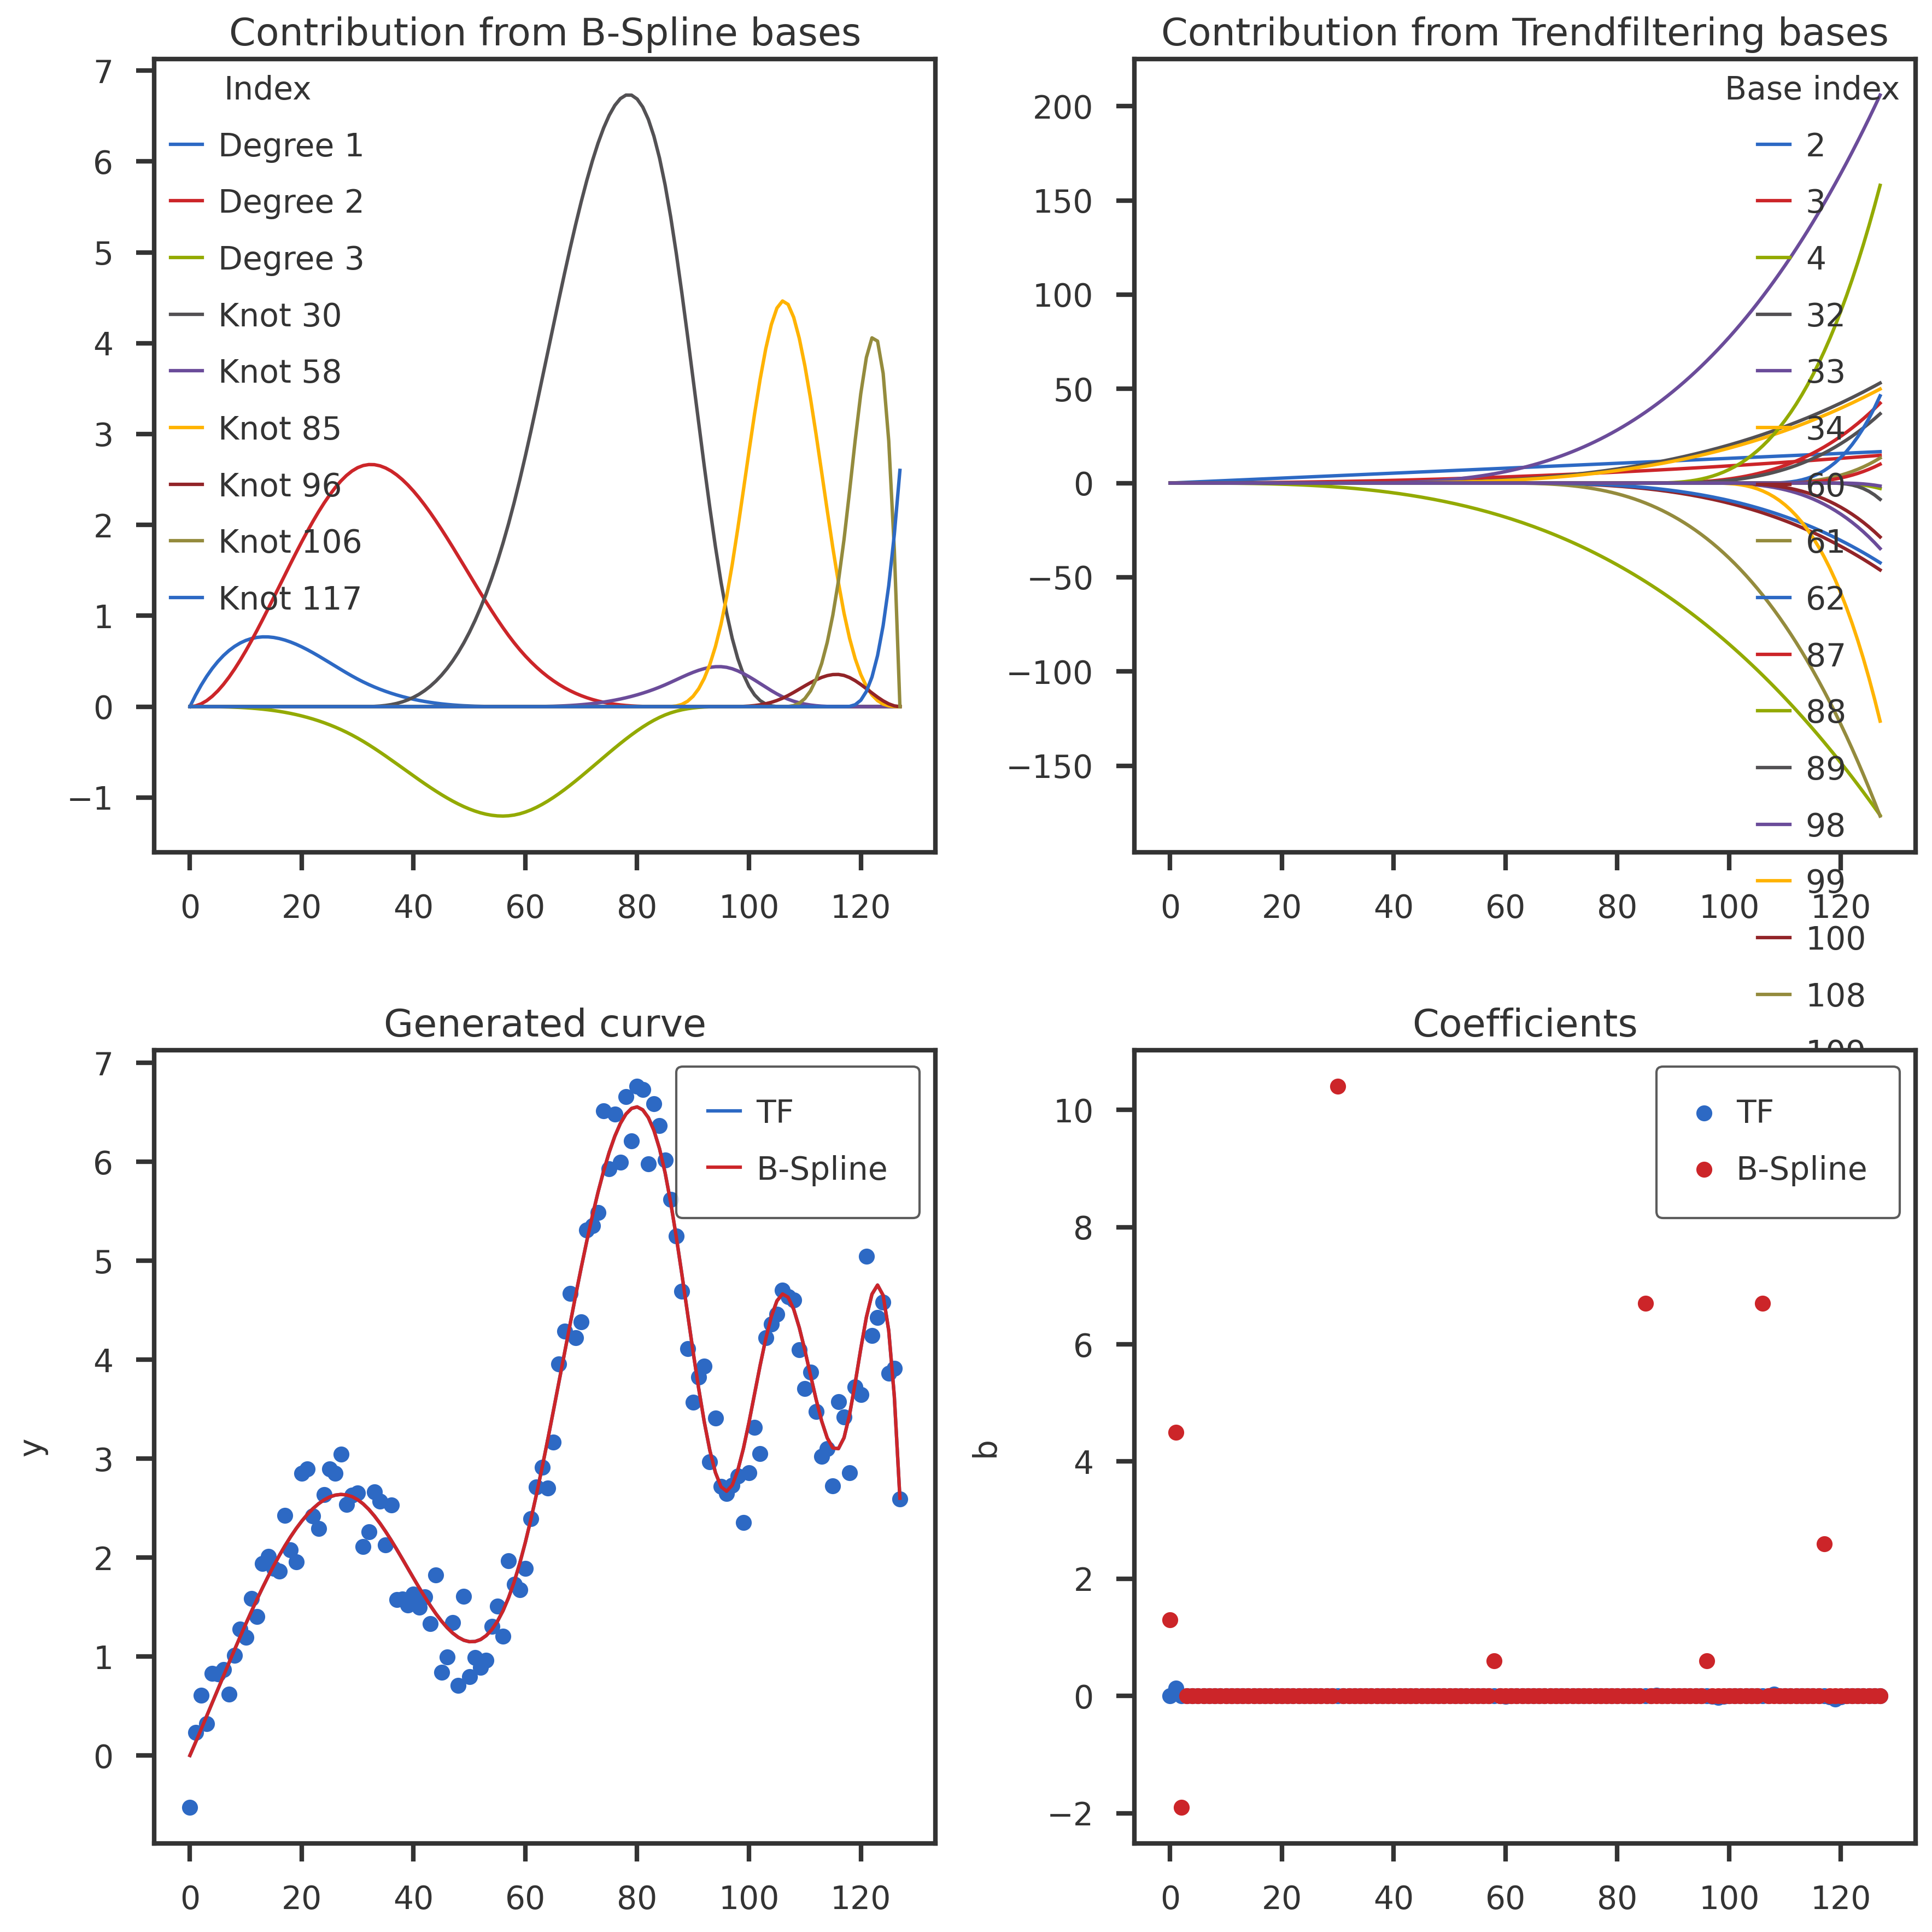

In [8]:
n = 128
x = np.linspace(0, 1, n)
np.random.seed(100)

# Hills example
x = np.linspace(0, n-1, n)
k = 6
degree = 3
strue = 0.3
include_intercept = False
knots = model.hills_knots(n, 2, 4)# / n
bfix = np.array([1.3, 4.5, -1.9, 10.4, 0.6, 6.7, 0.6, 6.7, 2.6])
# -----------------------

H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, 
                                            degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-4
                                           )
print(f"Signal-to-noise ratio: {snr:.3f}")

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
model.plot_data_from_bspline(axlist, x, y, knots, degree, G, Gb, H, btrue)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

### Distribution of coefficients for B-spline and Trendfiltering basis functions

How does the distribution of trendfiltering basis function look if the B-spline basis functions are normally distributed? The distribution of the coefficients deviates from the Gaussian distribution.

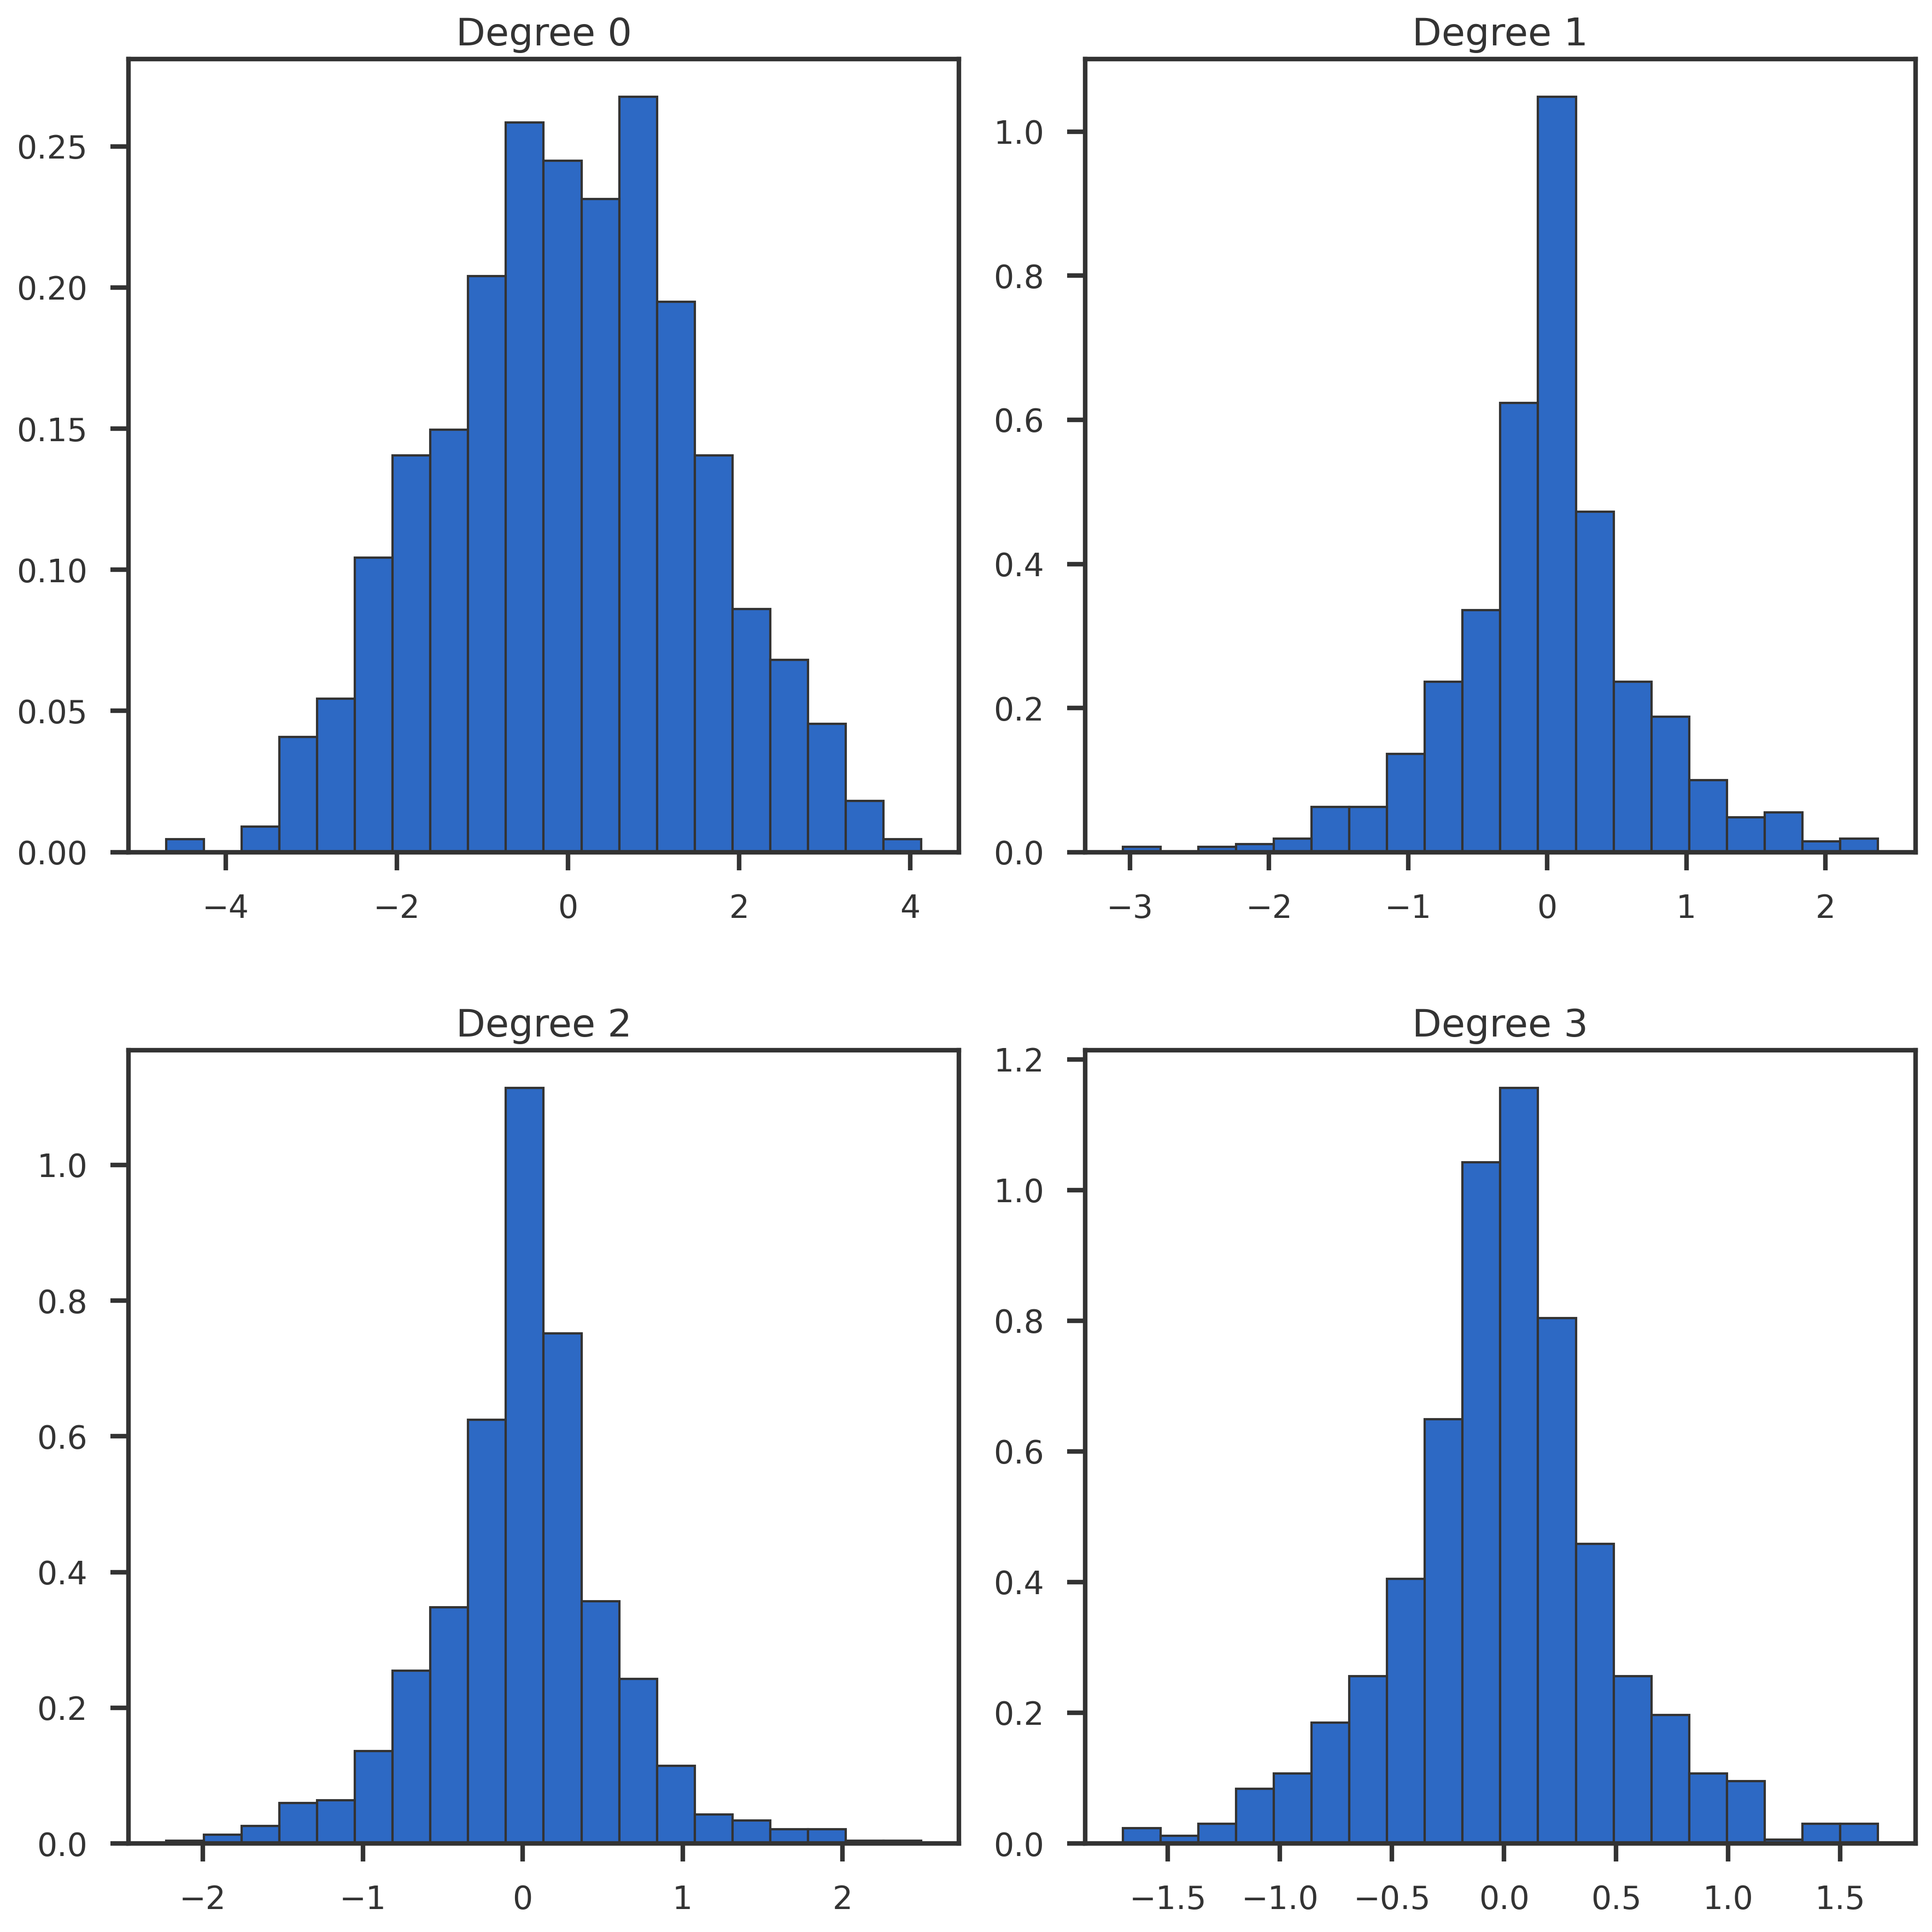

In [15]:
n = 1000
x = np.linspace(0, 1, n)
np.random.seed(100)
k = 500

fig = plt.figure(figsize = (12, 12))
axlist = [fig.add_subplot(2,2,i+1) for i in range(4)]
degree = 0
strue = 1.0
include_intercept = False

for i, degree in enumerate([0, 1, 2, 3]):
    knots = np.linspace(degree, n, k+2)[1:-1] / n
    bfix = np.random.normal(0, 1, size = k + degree)  
    H, y, ytest, btrue, snr, G, Gb = model.changepoint_from_bspline(x, knots, strue, degree = degree, 
                                            signal = "fixed", bfix = bfix,
                                            seed = 100, include_intercept = include_intercept,
                                            get_bsplines = True, eps = 1e-4)
    axlist[i].set_title(f"Degree {degree}")
    axlist[i].hist(btrue[btrue!=0], density = True)

plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()

#### Unsuccessful attempt  to generate coefficients for trendfiltering basis instead of generating via B-splines

In [23]:
x = np.arange(n)
knots = np.linspace(0, n, k+2, dtype = int)[1:-1]
new_knots = list()
new_bfix  = list()
for i in range(degree):
    #new_knots.append(i+1)
    new_bfix.append(bfix[i])
for i, knot in enumerate(knots):
    new_knots.append(knot)
    new_bfix.append(bfix[i+degree])
    new_knots.append(knot+1)
    new_bfix.append(-bfix[i+degree])
    
new_knots = np.array(new_knots)
new_bfix = np.array(new_bfix)

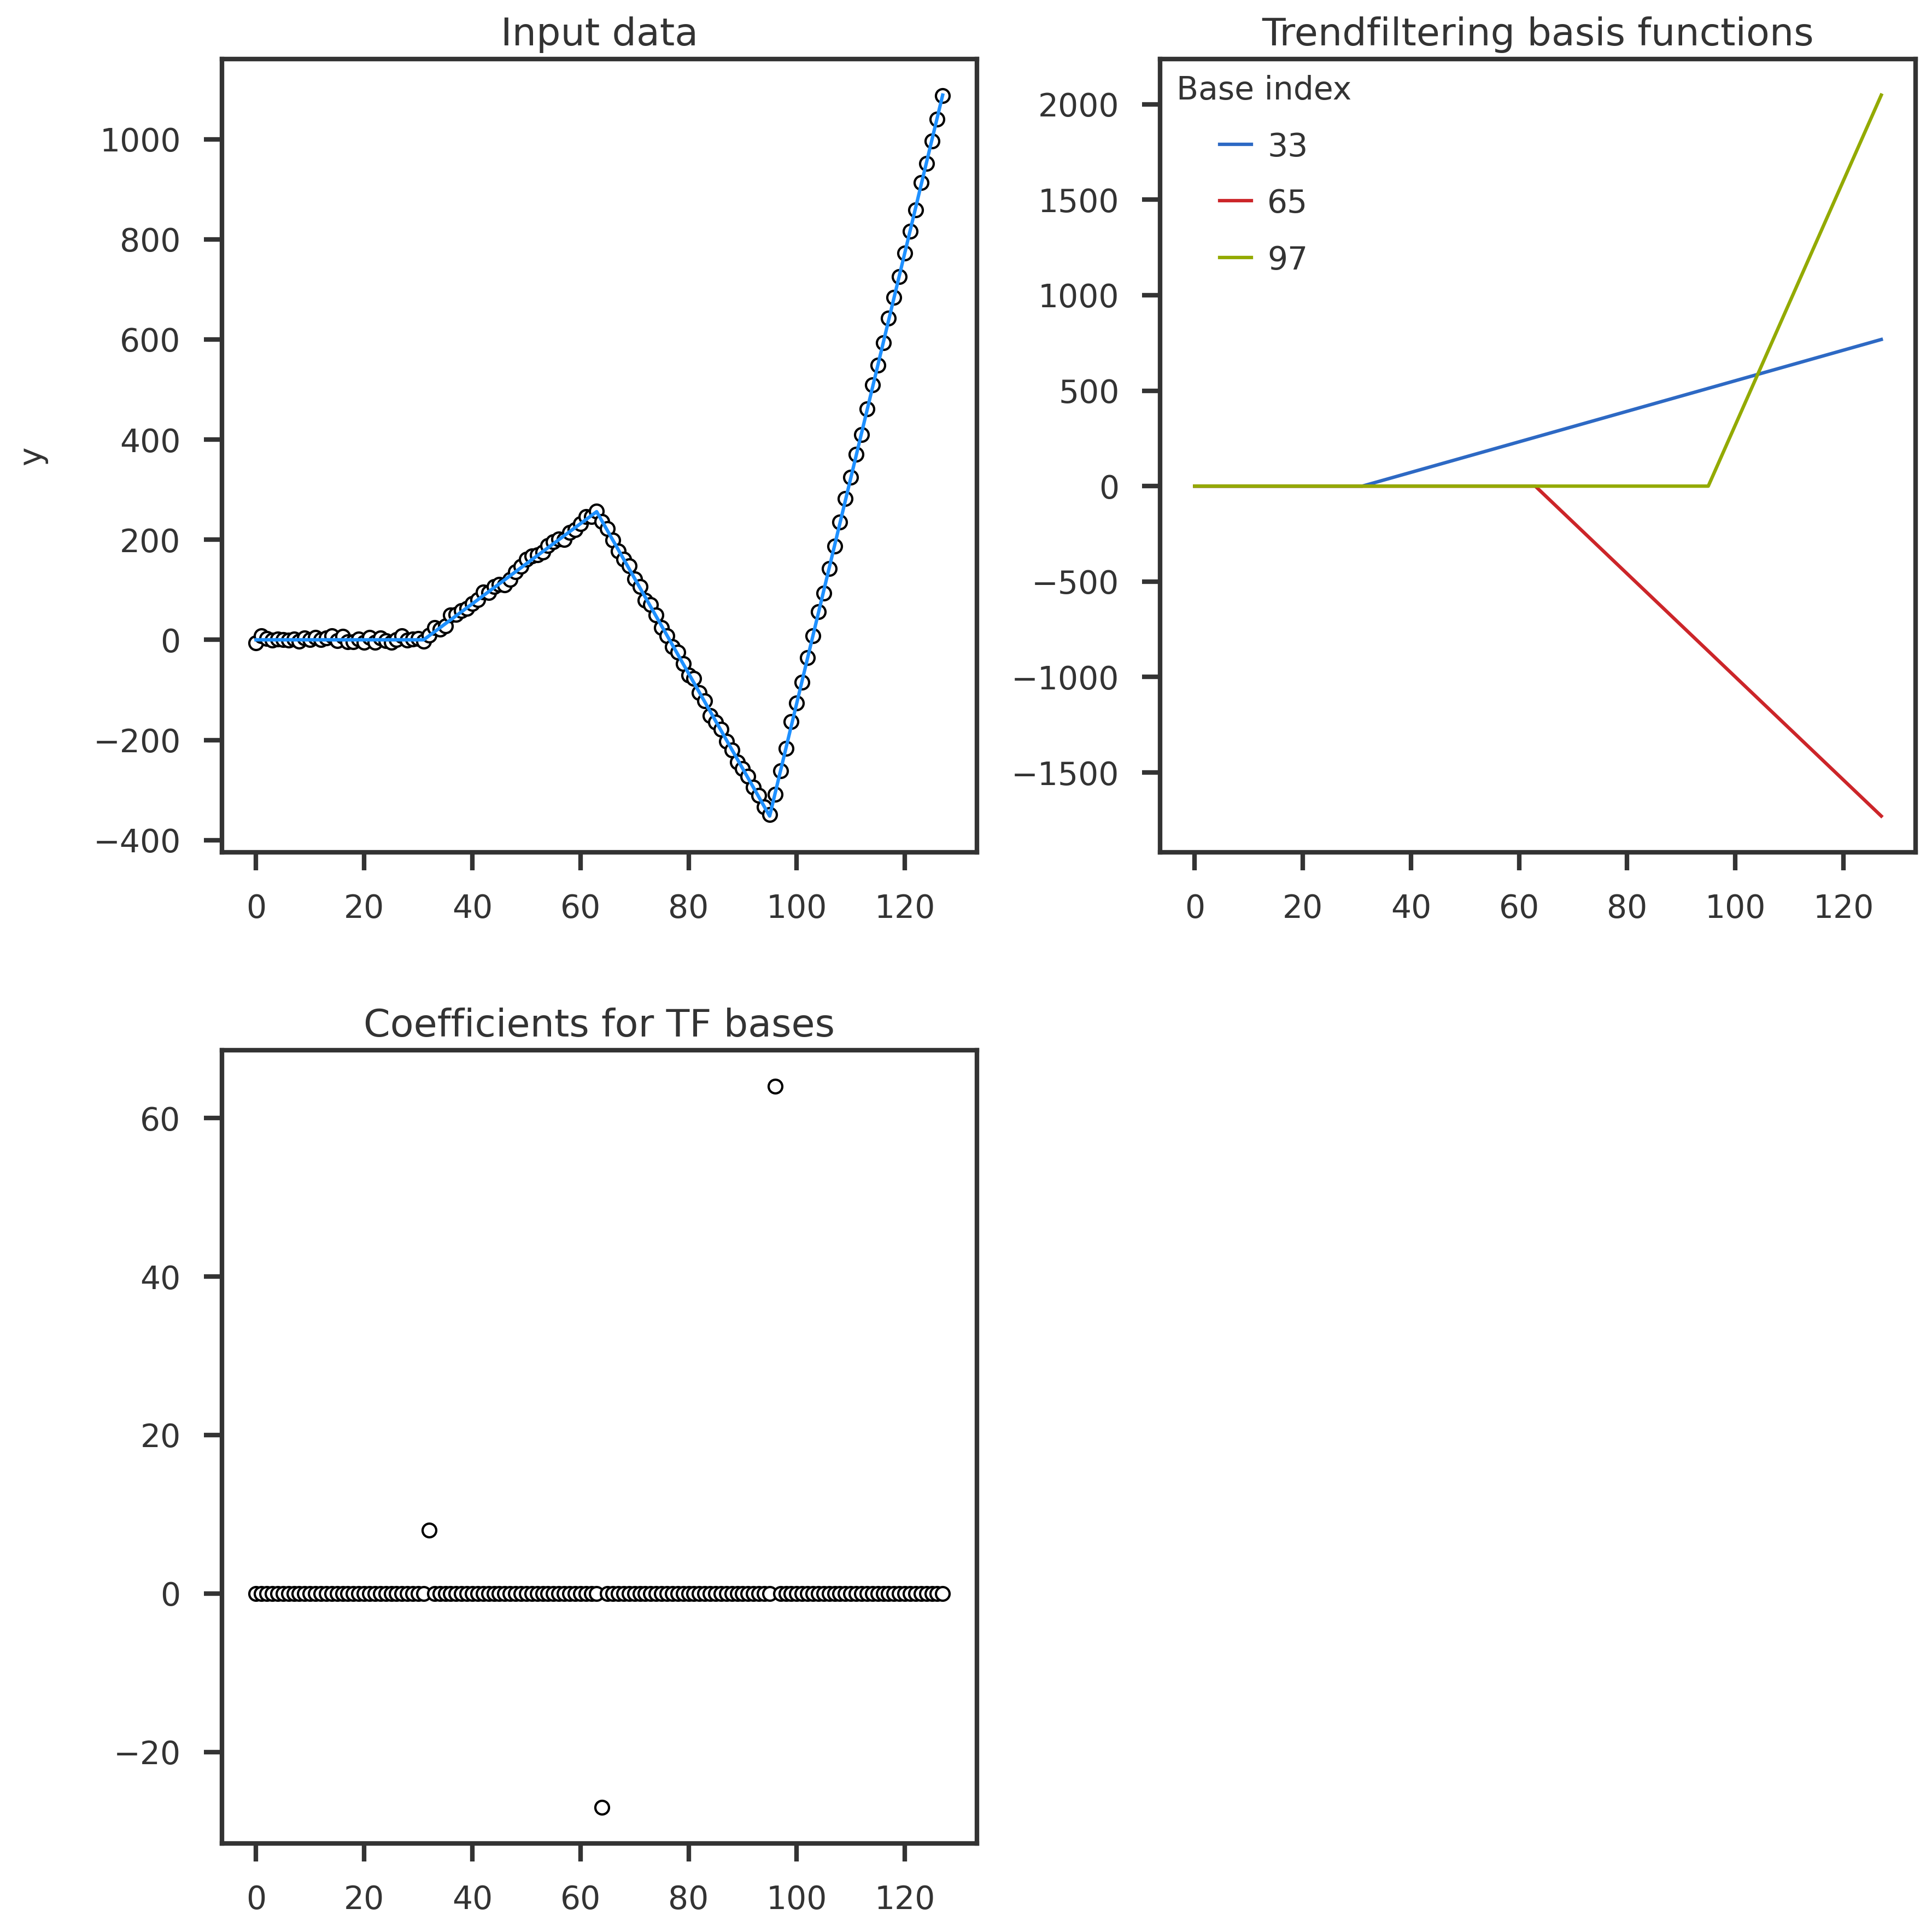

In [48]:
def changepoint(x, knots, std, degree = 0, signal = "gamma", seed = None,
                include_intercept = False, bfix = None):
    if seed is not None: np.random.seed(seed)
    n      = x.shape[0]
    nknots = knots.shape[0]
    nbases = nknots + degree + int(include_intercept)
    H      = model.trendfiltering_basis_matrix(n, degree)
    b      = np.zeros(n)
    kp     = np.array([np.argmin(np.abs(x - k)) for k in knots])
    b[kp]  = model.sample_betas(nbases, method = signal, bfix = bfix)[degree:]
    noise  = np.random.normal(0, std, size = n * 2)
    ytrue  = np.dot(H, b)
    y      = ytrue + noise[:n]
    ytest  = ytrue + noise[n:]
    signal = np.mean(np.square(b[b != 0]))
    snr    = signal / np.square(std)
    return H, y, ytest, b, snr


bfix_new = np.array([2, 2, -3, 4])
bfix_new = bfix_new * np.square(bfix_new)
H, y, ytest, btrue, snr = changepoint(x, knots, 4, 
                                      degree = degree, 
                                      signal = "fixed", 
                                      bfix = bfix_new,
                                      #bfix = np.random.normal(0, 1, size = new_knots.shape[0] + degree), #new_bfix,
                                      seed = 200, include_intercept = include_intercept
                                     )

fig = plt.figure(figsize = (12, 12))
nrow = 2
ncol = 2
ax1 = fig.add_subplot(nrow, ncol, 1)
ax2 = fig.add_subplot(nrow, ncol, 2)
ax3 = fig.add_subplot(nrow, ncol, 3)
#ax4 = fig.add_subplot(nrow, ncol, 4)
#ax5 = fig.add_subplot(nrow, ncol, 5)

#xvals = np.linspace(0, 1, y.shape[0]) #np.arange(n) / n
xvals = np.arange(n)
ax1.scatter(xvals, y, edgecolor = 'black', facecolor = 'white')
ax1.plot(xvals, np.dot(H, btrue), color = 'dodgerblue')
ax1.set_title("Input data")
ax1.set_ylabel("y")
#ax1.plot(x, bspline_bases * btrue, alpha = 0.1)
for i, b in enumerate(btrue):
    if b != 0:
        ax2.plot(xvals, b * H[:, i], label = f'{i+1}')
ax2.legend(title = "Base index")
ax2.set_title("Trendfiltering basis functions")

ax3.scatter(xvals, btrue, edgecolor = 'black', facecolor = 'white')
ax3.set_title("Coefficients for TF bases")

plt.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.show()